In [1]:
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#from statsmodels.tsa.seasonal import seasonal_decompose
#from statsmodels.tsa.statespace.sarimax import SARIMAX

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation, performance_metrics

import pickle
import requests

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)

Links
- US vaccine tracker
    - https://www.mayoclinic.org/coronavirus-covid-19/vaccine-tracker/
    - https://usafacts.org/visualizations/covid-vaccine-tracker-states/
- Interactive world wide tracker
    - https://ourworldindata.org/covid-vaccinations
- **vaccine data - https://data.cdc.gov/Vaccinations/COVID-19-Vaccinations-in-the-United-States-Jurisdi/unsk-b7fc
- **cases/deaths - https://data.cdc.gov/Case-Surveillance/United-States-COVID-19-Cases-and-Deaths-by-State-o/9mfq-cb36
- **forecast - https://covid.cdc.gov/covid-data-tracker/#forecasting_weeklydeaths
- **hospitalizations - https://gis.cdc.gov/grasp/COVIDNet/COVID19_5.html
- **hopitalizations data - https://www.cdc.gov/coronavirus/2019-ncov/science/forecasting/hospitalizations-forecasts.html
- **the repository - https://github.com/reichlab/covid19-forecast-hub#ensemble-model

http://localhost:8888/notebooks/Documents/UDEMY/UDEMY_TSA_FINAL/UDEMY_TSA_FINAL/08-Prophet-Library/01-Prophet-Forecast-Evaluations.ipynb

https://github.com/nicolasfauchereau/Auckland_Cycling/blob/master/notebooks/paper_day_weather.ipynb

In [139]:
def vax_data_update():
    
    '''
    Retrieve updated vax data
    Concat new updates to original dataframe
    Save new dataframe
    '''
    
    #Retrieve api data
    api_url = 'https://data.cdc.gov/resource/unsk-b7fc.json'
    results = requests.get(api_url).json()
    
    #Open pickled data
    infile = open('pickled_data/general_data/vax_df_clean.pickle','rb')
    vax_df_clean = pickle.load(infile)
    infile.close()
    
    #Append new data to list
    parsed_data = []
    for result in results:
        
        #Retrieve last date on current vax dataset
        last_date = str(vax_df_clean.sort_values('date', ascending = False).iloc[0]['date'])[:10]
        
        #Save data if date new, stop when false
        if result['date'][:10] > last_date:
            data = (result['date'][:10], result['location'],
                    result['administered_dose1_pop_pct'],
                    result['series_complete_pop_pct'])
            parsed_data.append(data)
        else:
            break
    
    #Convert list to dataframe
    new_data = pd.DataFrame(parsed_data,
                 columns = ['date', 'location',
                            'administered_dose1_pop_pct',
                            'series_complete_pop_pct'
                           ]
                )
    
    #Change dtypes
    new_data['date'] = pd.to_datetime(new_data['date'])
    new_data = new_data.astype({'administered_dose1_pop_pct': 'float',
                                'series_complete_pop_pct': 'float'})
    
    #Concat to old dataframe
    vax_df_clean = pd.concat([new_data, vax_df_clean])
    
    #Save results
    pickle_out = open('pickled_data/general_data/vax_df_clean.pickle','wb')
    pickle.dump(vax_df_clean, pickle_out)
    pickle_out.close()
    
    #Return new dataframe
    return vax_df_clean

In [140]:
#States full name. location_name
hospitalizations_df = pd.read_csv('https://raw.githubusercontent.com/reichlab/covid19-forecast-hub/master/data-truth/truth-Incident%20Hospitalizations.csv')
#Same as hospitalizations_df
deaths_df = pd.read_csv('https://raw.githubusercontent.com/reichlab/covid19-forecast-hub/master/data-truth/truth-Incident%20Deaths.csv')

#States Abbreviated. location_abbreviation
hospitalizations_outliers = pd.read_csv('https://raw.githubusercontent.com/reichlab/covid19-forecast-hub/master/data-anomalies/outliers-inc-hosps.csv',
                                        index_col = 0)

broken_dates = hospitalizations_outliers[hospitalizations_outliers['date'] > '2022-01-01'].index
hospitalizations_outliers.drop(index = broken_dates, inplace = True)

#Same as hospitalization_outliers
death_outliers = pd.read_csv('https://raw.githubusercontent.com/reichlab/covid19-forecast-hub/master/data-anomalies/outliers-inc-deaths.csv',
                             index_col = 0)

#States are abbreviated
vax_df_clean = vax_data_update()

In [141]:
def table_cleaner(state_abbreviated,
                  hospitalizations_df = hospitalizations_df,
                  deaths_df = deaths_df,
                  hospitalizations_outliers = hospitalizations_outliers,
                  death_outliers = death_outliers,
                  vax_df_clean = vax_df_clean):
    '''
    Clean and concat desired data into Prophet's format
    Returns deaths/hospitalizations w/vax data
    Returns outliers in Prophet's holiday format
    '''
    
    #Import pickled dictionary of state name/abbreviation
    load_states_dict = open('pickled_data/general_data/states.pickle','rb')
    states = pickle.load(load_states_dict)
    load_states_dict.close()
    
    #Set state name per abbreviation
    full_state = states[state_abbreviated]
    
    #----- Hopitalizations/Fatalities Data -----#
    
    #Retrieve state's hospitalization data
    hosp_df = hospitalizations_df[hospitalizations_df['location_name'] == full_state].sort_values('date')[['date', 'value']]
    #Reformat column names for Prophet
    hosp_df.rename(columns = {'value': 'hospitalizations',
                              'date': 'ds'},
                   inplace = True
                  )
    #Adjust to datetime & set index to date
    hosp_df['ds'] = pd.to_datetime(hosp_df['ds'])
    hosp_df.set_index(keys = 'ds', drop = True, inplace = True)
    
    #Retrieve state's fatality data
    death_df = deaths_df[deaths_df['location_name'] == full_state].sort_values('date')[['date', 'value']]
    #Reformat column names for Prophet
    death_df.rename(columns = {'value': 'deaths',
                               'date': 'ds'},
                   inplace = True
                  )
    #Adjust to datetime & set index to date
    death_df['ds'] = pd.to_datetime(death_df['ds'])
    death_df.set_index(keys = 'ds', drop = True, inplace = True)
    
    #Concat hospitalization/fatality dataframes
    death_hosp = pd.concat([hosp_df, death_df], join = 'outer', axis = 1)
    #Fill early hospital data with 0
    death_hosp['hospitalizations'] = death_hosp['hospitalizations'].fillna(0)
    #Resample as weekly data
    death_hosp = death_hosp.resample('W').mean()
    
    #----- Vax Data -----#
    
    #Retrieve state's vax data
    state_vax = vax_df_clean[vax_df_clean['location'] == state_abbreviated]
    #Reformat column names for Prophet 
    state_vax.rename(columns = {'date': 'ds'},
                    inplace = True
                   )
    #Adjust to datetime & set index to date
    state_vax['ds'] = pd.to_datetime(state_vax['ds'])
    state_vax.set_index(keys = 'ds', drop = True, inplace = True)
    #Resample as weekly data
    state_vax = state_vax.resample('W').mean()
    
    #Concat hospitalization/fatality and vax dataframes
    final_df = pd.concat([death_hosp, state_vax], join = 'outer', axis = 1)
    
    #Fill missing early data with 0's
    columns = ['administered_dose1_pop_pct', 'series_complete_pop_pct']
    final_df[columns] = final_df[columns].fillna(0)
    
    #Drop data missing due to update imbalance
    final_df.dropna(inplace = True)
    final_df.reset_index(inplace = True)
    
    #----- Outlier Data -----#
    
    #Retrieve state's hospitalization outliers
    hosp_out = list(set(hospitalizations_outliers[hospitalizations_outliers['location_abbreviation'] == state_abbreviated]['date']))
    #Format for Prophet
    hosp_out_df = pd.DataFrame({
        'holiday': 'hosp_outliers',
        'ds': pd.to_datetime(hosp_out)    
    })
    #Retrive state's fatality outliers
    deaths_out = list(set(death_outliers[death_outliers['location_abbreviation'] == state_abbreviated]['date']))
    #Format for Prophet
    deaths_out_df = pd.DataFrame({
        'holiday': 'deaths_outliers',
        'ds': pd.to_datetime(hosp_out)    
    })
    #Concat holidays
    outliers = pd.concat([hosp_out_df, deaths_out_df])
    
    
    #Return final_df, outliers
    pickle_final_df = open(f'pickled_data/state_data_pickled/{state_abbreviated}_final_df.pickle','wb')
    pickle.dump(final_df, pickle_final_df)
    pickle_final_df.close()

    pickle_holidays = open(f'pickled_data/state_data_pickled/{state_abbreviated}_outliers.pickle','wb')
    pickle.dump(outliers, pickle_holidays)
    pickle_holidays.close()

In [142]:
load_states_dict = open('pickled_data/general_data/states.pickle','rb')
states = pickle.load(load_states_dict)
load_states_dict.close()

for state in list(states.keys()):
    table_cleaner(state)

In [143]:
def make_model(state_abbreviation):
    
    '''
    Run predictions for vax rates
    Use vax predictions for hospitalization/fatality models
    '''
    
    #----- Initial Data Load -----#
    
    #State separated data
    load_state_df = open(f'pickled_data/state_data_pickled/{state_abbreviation}_final_df.pickle','rb')
    the_state_df = pickle.load(load_state_df)
    load_state_df.close()
    
    #State outliers
    load_state_outliers = open(f'pickled_data/state_data_pickled/{state_abbreviation}_outliers.pickle','rb')
    state_outliers = pickle.load(load_state_outliers)
    load_state_outliers.close()
    
    #Vax grid searched parameters
    load_dose_one_param = open(f'pickled_data/model_params/{state_abbreviation}_dose_one_param.pickle','rb')
    dose_one_param = pickle.load(load_dose_one_param)
    load_dose_one_param.close()
    load_series_complete_param = open(f'pickled_data/model_params/{state_abbreviation}_series_complete_param.pickle','rb')
    series_complete_param = pickle.load(load_series_complete_param)
    load_series_complete_param.close()
    
    #Separate Regressors to run predictions on
    #Rename to Prophet naming conventions
    dose_one_df = the_state_df[['ds', 'administered_dose1_pop_pct']].rename(columns = {'administered_dose1_pop_pct': 'y'})
    series_complete_df = the_state_df[['ds', 'series_complete_pop_pct']].rename(columns = {'series_complete_pop_pct': 'y'})
    
    #----- Regressor Predictions -----#
    
    #Instantiate model for dose one vax
    dose_one_model = Prophet(n_changepoints = 30,
                             changepoint_prior_scale = dose_one_param)

    dose_one_model.fit(dose_one_df[dose_one_df['y'] > 0])
    
    #Make future dataframe and create predictions 1 month forward
    dose_one_future = dose_one_model.make_future_dataframe(periods = 4, freq = 'W')
    dose_one_forecast = dose_one_model.predict(dose_one_future)

    #Instantiate model for complete vax
    series_complete_model = Prophet(n_changepoints = 30,
                                    changepoint_prior_scale = series_complete_param)

    series_complete_model.fit(series_complete_df[series_complete_df['y'] > 0])
    
    #Make future dataframe and create predictions 1 month forward
    series_complete_future = series_complete_model.make_future_dataframe(periods = 4, freq = 'W')
    series_complete_forecast = series_complete_model.predict(series_complete_future)

    #Concat predictions
    vax_forecast = pd.concat(
        [dose_one_forecast[['ds', 'yhat']][-4:].\
         set_index(keys = 'ds', drop = True).\
         rename(columns = {'yhat': 'administered_dose1_pop_pct'}),

         series_complete_forecast[['ds', 'yhat']][-4:].\
         set_index(keys = 'ds', drop = True).\
         rename(columns = {'yhat': 'series_complete_pop_pct'})],
        axis = 1
    ).reset_index()

    #Set predictions index to follow full dataframe
    start_index = the_state_df.tail(1).index.values[0] + 1
    vax_forecast.index = pd.RangeIndex(start_index, start_index + 4)
    
    #Concat predictions to end of full dataframe
    the_state_df = pd.concat([the_state_df, vax_forecast])
    
    #Export update dataframe
    pickled_new_state_df = open(f'pickled_data/state_vax_pred_pickled/{state_abbreviation}_vax_pred_df.pickle','wb')
    pickle.dump(the_state_df, pickled_new_state_df)
    pickled_new_state_df.close()
    
    #----- Hospitalization/Fatality Models -----#
    
    #Load in grid searched parameters
    load_deaths_params = open(f'pickled_data/model_params/{state_abbreviation}_deaths_params.pickle','rb')
    deaths_params = pickle.load(load_deaths_params)
    load_deaths_params.close()

    load_hosp_params = open(f'pickled_data/model_params/{state_abbreviation}_hosp_params.pickle','rb')
    hosp_params = pickle.load(load_hosp_params)
    load_hosp_params.close()
    
    #Separate targets
    #Rename to Prophet naming conventions
    state_deaths = the_state_df.drop(columns = 'hospitalizations').rename(columns = {'deaths': 'y'})
    state_hospitalizations = the_state_df.drop(columns = 'deaths').rename(columns = {'hospitalizations': 'y'})
    
    #Covid Fatalities Model
    deaths_model = Prophet(n_changepoints = 30,
                           changepoint_range = deaths_params['changepoint_range'],
                           changepoint_prior_scale = deaths_params['changepoint_prior_scale'],
                           holidays = state_outliers[state_outliers['holiday'] == 'deaths_outliers'])
    
    #Add regressors w/ their vax predictions
    deaths_model.add_regressor('administered_dose1_pop_pct')
    deaths_model.add_regressor('series_complete_pop_pct')
    
    #Fit model on current data
    deaths_model.fit(state_deaths[:-4])
    
    #Covid Hospitalizations Model
    hosp_model = Prophet(n_changepoints = 30,
                         changepoint_range = hosp_params['changepoint_range'],
                         changepoint_prior_scale = hosp_params['changepoint_prior_scale'],
                         holidays = state_outliers[state_outliers['holiday'] == 'hosp_outliers'])
    
    #Add regressors w/ their vax predictions
    hosp_model.add_regressor('administered_dose1_pop_pct')
    hosp_model.add_regressor('series_complete_pop_pct')
    
    #Fit model on current data
    hosp_model.fit(state_hospitalizations[:-4])
    
    #----- Export models -----#
    
    #Vax models for metrics
    pickle_dose_one_model = open(f'pickled_data/models_pickled/{state_abbreviation}_dose_one_model.pickle','wb')
    pickle.dump(dose_one_model, pickle_dose_one_model)
    pickle_dose_one_model.close()

    pickle_series_complete_model = open(f'pickled_data/models_pickled/{state_abbreviation}_series_complete_model.pickle','wb')
    pickle.dump(series_complete_model, pickle_series_complete_model)
    pickle_series_complete_model.close() 
    
    #Fatality/Hospitaliztion models for later use
    pickle_deaths_model = open(f'pickled_data/models_pickled/{state_abbreviation}_deaths_model.pickle','wb')
    pickle.dump(deaths_model, pickle_deaths_model)
    pickle_deaths_model.close()

    pickle_hosp_model = open(f'pickled_data/models_pickled/{state_abbreviation}_hosp_model.pickle','wb')
    pickle.dump(hosp_model, pickle_hosp_model)
    pickle_hosp_model.close()

In [356]:
load_states_dict = open('pickled_data/general_data/states.pickle','rb')
states = pickle.load(load_states_dict)
load_states_dict.close()

for state in list(states.keys()):
    make_model(state)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonali

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonali

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonali

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonali

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonali

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonali

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonali

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 17.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonali

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonali

In [144]:
def visualization_predictions(state_abbreviation, multiplier):
    
    '''
    Create predictions based on vax multiplier
    '''
    
    #----- Data Load In ----- #
    load_deaths_model = open(f'pickled_data/models_pickled/{state_abbreviation}_deaths_model.pickle','rb')
    deaths_model = pickle.load(load_deaths_model)
    load_deaths_model.close()
    
    load_hosp_model = open(f'pickled_data/models_pickled/{state_abbreviation}_hosp_model.pickle','rb')
    hosp_model = pickle.load(load_hosp_model)
    load_hosp_model.close()
    
    load_vax_pred = open(f'pickled_data/state_vax_pred_pickled/{state_abbreviation}_vax_pred_df.pickle','rb')
    vax_pred_df = pickle.load(load_vax_pred)
    load_vax_pred.close()
    
    #Separate deaths/hospitalizations and rename columns
    state_deaths = vax_pred_df.drop(columns = 'hospitalizations').rename(columns = {'deaths': 'y'})
    state_hospitalizations = vax_pred_df.drop(columns = 'deaths').rename(columns = {'hospitalizations': 'y'})
    
    #----- Fatality Predictions -----#
    
    #Create future dataframe for predictions
    deaths_future = deaths_model.make_future_dataframe(periods = 4, freq = 'W')
    
    #Add regressor columns to future dataframe
    columns = ['administered_dose1_pop_pct', 'series_complete_pop_pct']
    #Multiplier to allow value alterations
    deaths_future[columns] = state_deaths[columns] * multiplier
    #Cap max vaccination rate at 100%
    deaths_future[columns[0]].clip(upper = 100., inplace = True)
    deaths_future[columns[1]].clip(upper = 100., inplace = True)
    
    #Create predictions, cap lower limit as 0
    deaths_forecast = deaths_model.predict(deaths_future)
    deaths_forecast['yhat'].clip(lower = 0, inplace = True)
   
    #----- Hospitalizations Predictions -----#

    #Create future dataframe for predictions
    hosp_future = hosp_model.make_future_dataframe(periods = 4, freq = 'W')
    
    #Add regressor columns to future dataframe
    #Multiplier to allow value alterations
    hosp_future[columns] = state_deaths[columns] * multiplier
    #Cap max vaccination rate at 100%
    hosp_future[columns[0]].clip(upper = 100., inplace = True)
    hosp_future[columns[1]].clip(upper = 100., inplace = True)
    
    #Create predictions, cap lower limit as 0
    hosp_forecast = hosp_model.predict(hosp_future) 
    hosp_forecast['yhat'].clip(lower = 0, inplace = True)        
    
    return deaths_forecast[['ds', 'yhat']], hosp_forecast[['ds', 'yhat']], deaths_future

In [145]:
def make_fig(state_abbreviation):
    
    '''
    Create/save figure
    '''
        
    # Create figure
    fig = make_subplots(rows=2, cols=1,
                        shared_xaxes = True,
                        specs=[[{'type': 'scatter'}],
                               [{'type': 'scatter'}]
                              ],
                        row_heights = [10,
                                       20],
                        subplot_titles=('Vaccination Rate',
                                        'Weekly Hospitalizations & Fatalities')
                       )


    # Add traces, one for each slider step
    for step in np.arange(0, 2, 0.05):

        death_forecast, hosp_forecast, vax_df = visualization_predictions(state_abbreviation, step)

        fig.add_traces(
            [
            go.Scatter(
                visible = False,
                line = dict(color = '#7dfffc', width=6),
                name = 'Dose 1 Pop. %',
                x = vax_df['ds'],
                y = vax_df['administered_dose1_pop_pct']
            ),
            go.Scatter(
                visible = False,
                line = dict(color = '#7dff80', width=6),
                name = 'Series Complete Pop. %',
                x = vax_df['ds'],
                y = vax_df['series_complete_pop_pct']
            )
            ],
            rows = [1, 1], cols = [1, 1]
        )

        fig.add_traces(
            [
            go.Scatter(
                visible = False,
                line = dict(color = '#ff2828', width=6),
                name = 'Fatalities',
                x = death_forecast['ds'],
                y = death_forecast['yhat']
            ),
            go.Scatter(
                visible = False,
                line = dict(color = '#ff9428', width=6),
                name = 'Hospitalizations',
                x = hosp_forecast['ds'],
                y = hosp_forecast['yhat']
            )
            ],
            rows = [2, 2], cols = [1, 1]
        )

    # Make middle trace visible
    middle_trace = int(len(fig.data)/2)
    for i in range(middle_trace, middle_trace + 4):
        fig.data[i].visible = True

    # Create and add slider
    steps = []
    for i in range(0, len(fig.data), 8):
        step = dict(
            method = 'update',
            args = [{'visible': [False] * len(fig.data)},
                    {'title': f'{state_abbreviation} Vaccine Rate Multipler at: ' + str(i/80)}],
        )
        step['args'][0]['visible'][i] = True

        try:
            step['args'][0]['visible'][i+3] = True
        except:
            continue
        try:
            step['args'][0]['visible'][i+2] = True
        except:
            continue
        try:
            step['args'][0]['visible'][i+1] = True
        except:
            continue
        steps.append(step)

    sliders = [dict(
        active = 10,
        currentvalue = {'prefix': 'Vaccination Rate Multiplier: '},
        pad = {'t': 50},
        steps = steps
    )]

    fig.update_layout(
        sliders = sliders,
        yaxis_range = [0, 100]
    )

    pickle_graph = open(f'pickled_data/graphs_pickled/{state_abbreviation}_graph.pickle', 'wb')
    pickle.dump(fig, pickle_graph)
    pickle_graph.close()

In [12]:
load_states_dict = open('pickled_data/general_data/states.pickle','rb')
states = pickle.load(load_states_dict)
load_states_dict.close()

for state in list(states.keys()):
    make_fig(state)

In [146]:
def show_fig(state_abbreviation):
    
    '''
    Read in figure and show
    '''
    
    load_graph = open(f'pickled_data/graphs_pickled/{state_abbreviation}_graph.pickle','rb')
    fig = pickle.load(load_graph)
    load_graph.close()

    fig.show()

In [30]:
from prophet.plot import plot_cross_validation_metric

In [147]:
def score_check(state_abbreviation, save_df):
    
    load_dose_one_model = open(f'pickled_data/models_pickled/{state_abbreviation}_dose_one_model.pickle','rb')
    dose_one_model = pickle.load(load_dose_one_model)
    load_dose_one_model.close()

    load_series_complete_model = open(f'pickled_data/models_pickled/{state_abbreviation}_series_complete_model.pickle','rb')
    series_complete_model = pickle.load(load_series_complete_model)
    load_series_complete_model.close()
    
    load_deaths_model = open(f'pickled_data/models_pickled/{state_abbreviation}_deaths_model.pickle','rb')
    deaths_model = pickle.load(load_deaths_model)
    load_deaths_model.close()

    load_hosp_model = open(f'pickled_data/models_pickled/{state_abbreviation}_hosp_model.pickle','rb')
    hosp_model = pickle.load(load_hosp_model)
    load_hosp_model.close()
    
    dose_one_cv = cross_validation(dose_one_model,
                                   horizon = '4 W',
                                   disable_tqdm = True)
    
    dose_one_mape = performance_metrics(dose_one_cv[dose_one_cv['y'] > 0 ]).iloc[-1]['mape']
    
    
    series_complete_cv = cross_validation(series_complete_model,
                                          horizon = '4 W',
                                          disable_tqdm = True)
    
    series_complete_mape = performance_metrics(series_complete_cv[series_complete_cv['y'] > 0 ]).iloc[-1]['mape']
    
    
    deaths_model_cv = cross_validation(deaths_model,
                                       horizon = '4 W',
                                       period = '12 W',
                                       disable_tqdm = True)
    
    deaths_model_mape = performance_metrics(deaths_model_cv[deaths_model_cv['y'] > 0 ]).iloc[-1]['mape']
    
    
    hosp_model_cv = cross_validation(hosp_model,
                                     horizon = '4 W',
                                     period = '12 W',
                                     disable_tqdm = True)
    
    hosp_model_mape = performance_metrics(hosp_model_cv[hosp_model_cv['y'] > 0 ]).iloc[-1]['mape']
    
    return save_df.append({'state': state_abbreviation,
                           'dose_one_score': round(dose_one_mape, 2),
                           'series_complete_score': round(series_complete_mape, 2),
                           'fatality_score': round(deaths_model_mape, 2),
                           'hosp_score': round(hosp_model_mape, 2)
                          },
                          ignore_index = True
                         )

In [193]:
initial_state = pd.DataFrame(columns = ['state',
                                        'dose_one_score',
                                        'series_complete_score',
                                        'fatality_score',
                                        'hosp_score'])

load_states_dict = open('pickle/states.pickle','rb')
states = pickle.load(load_states_dict)
load_states_dict.close()

for state in list(states.keys()):
    initial_state = score_check(state, initial_state)

pickle_initial_state = open(f'pickle/initial_state.pickle', 'wb')
pickle.dump(initial_state, pickle_initial_state)
pickle_initial_state.close()

initial_state

INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 20.
INFO:prophet:Making 6 forecasts wit

INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 25.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Making 6 forecasts wit

INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 20.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 25.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet

INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 20.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 25.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater

INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 20.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 25.
INFO:prophet:Making 4 forecasts wit

INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 20.
INFO:prophet:Making 6 forecasts wit

INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 25.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Making 6 forecasts wit

INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 20.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 25.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet

state  dose_one_score  series_complete_score  fatality_score  hosp_score
0     AK            0.01                   0.07            0.78        1.18
1     AL            0.03                   0.10            2.18        0.66
2     AR            0.02                   0.09            1.50        1.99
3     AZ            0.02                   0.05            1.91        1.37
4     CA            0.05                   0.08            1.31        0.86
5     CO            0.05                   0.12            2.44        1.05
6     CT            0.05                   0.09            2.45        0.91
7     DE            0.05                   0.11            3.96        0.80
8     FL            0.04                   0.09            0.71        1.00
9     GA            0.02                   0.14            1.02        0.77
10    HI            0.10                   0.15            5.35        1.45
11    IA            0.04                   0.09            0.60        1.17
12    ID            0.03                   0.08            1.50        0.59
13    IL            0.05                   0.09            1.35        0.52
14    IN            0.04                   0.07            0.99        0.98
15    KS            0.02                   0.06            0.80        0.77
16    KY            0.03                   0.05            1.18        0.49
17    LA            0.01                   0.06            0.68        1.41
18    MA            0.07                   0.11            1.14        1.55
19    MD            0.05                   0.11            1.20        1.00
20    ME            0.06                   0.12            0.53        1.80
21    MI            0.05                   0.10            1.41        1.01
22    MN            0.06                   0.10            2.10        0.54
23    MO            0.03                   0.06            0.90        2.29
24    MS            0.02                   0.06            0.45        0.83
25    MT            0.03                   0.08            1.53        0.87
26    NC            0.05                   0.06            0.51        1.08
27    ND            0.02                   0.06            2.99        0.81
28    NE            0.02                   0.09            9.13        0.76
29    NH            0.03                   0.14            0.97        0.74
30    NJ            0.06                   0.10            1.38        0.82
31    NM            0.02                   0.07            1.00        1.30
32    NV            0.02                   0.09            0.77        0.65
33    NY            0.05                   0.08            2.24        1.48
34    OH            0.04                   0.10            2.27        0.66
35    OK            0.01                   0.03            1.22        0.62
36    OR            0.08                   0.12            0.53        0.51
37    PA            0.06                   0.10            1.22        1.09
38    RI            0.06                   0.08            1.71        1.59
39    SC            0.02                   0.08            1.15        1.29
40    SD            0.01                   0.05            0.96        1.45
41    TN            0.03                   0.05            0.94        1.23
42    TX            0.03                   0.09            0.73        0.61
43    UT            0.03                   0.09            0.59        0.50
44    VA            0.05                   0.11            4.27        0.68
45    VT            0.11                   0.14            3.36        3.93
46    WA            0.06                   0.10            0.81        0.76
47    WI            0.03                   0.08            1.03        0.89
48    WV            0.02                   0.06            2.78        1.19
49    WY            0.01                   0.08            1.03        0.78

In [194]:
initial_state

state  dose_one_score  series_complete_score  fatality_score  hosp_score
0     AK            0.01                   0.07            0.78        1.18
1     AL            0.03                   0.10            2.18        0.66
2     AR            0.02                   0.09            1.50        1.99
3     AZ            0.02                   0.05            1.91        1.37
4     CA            0.05                   0.08            1.31        0.86
5     CO            0.05                   0.12            2.44        1.05
6     CT            0.05                   0.09            2.45        0.91
7     DE            0.05                   0.11            3.96        0.80
8     FL            0.04                   0.09            0.71        1.00
9     GA            0.02                   0.14            1.02        0.77
10    HI            0.10                   0.15            5.35        1.45
11    IA            0.04                   0.09            0.60        1.17
12    ID            0.03                   0.08            1.50        0.59
13    IL            0.05                   0.09            1.35        0.52
14    IN            0.04                   0.07            0.99        0.98
15    KS            0.02                   0.06            0.80        0.77
16    KY            0.03                   0.05            1.18        0.49
17    LA            0.01                   0.06            0.68        1.41
18    MA            0.07                   0.11            1.14        1.55
19    MD            0.05                   0.11            1.20        1.00
20    ME            0.06                   0.12            0.53        1.80
21    MI            0.05                   0.10            1.41        1.01
22    MN            0.06                   0.10            2.10        0.54
23    MO            0.03                   0.06            0.90        2.29
24    MS            0.02                   0.06            0.45        0.83
25    MT            0.03                   0.08            1.53        0.87
26    NC            0.05                   0.06            0.51        1.08
27    ND            0.02                   0.06            2.99        0.81
28    NE            0.02                   0.09            9.13        0.76
29    NH            0.03                   0.14            0.97        0.74
30    NJ            0.06                   0.10            1.38        0.82
31    NM            0.02                   0.07            1.00        1.30
32    NV            0.02                   0.09            0.77        0.65
33    NY            0.05                   0.08            2.24        1.48
34    OH            0.04                   0.10            2.27        0.66
35    OK            0.01                   0.03            1.22        0.62
36    OR            0.08                   0.12            0.53        0.51
37    PA            0.06                   0.10            1.22        1.09
38    RI            0.06                   0.08            1.71        1.59
39    SC            0.02                   0.08            1.15        1.29
40    SD            0.01                   0.05            0.96        1.45
41    TN            0.03                   0.05            0.94        1.23
42    TX            0.03                   0.09            0.73        0.61
43    UT            0.03                   0.09            0.59        0.50
44    VA            0.05                   0.11            4.27        0.68
45    VT            0.11                   0.14            3.36        3.93
46    WA            0.06                   0.10            0.81        0.76
47    WI            0.03                   0.08            1.03        0.89
48    WV            0.02                   0.06            2.78        1.19
49    WY            0.01                   0.08            1.03        0.78

In [148]:
def initial_fig(state_abbreviation):
    
    '''
    Read in initial figures and show
    '''
    
    load_graph = open(f'pickled_data/initial_graphs_pickled/{state_abbreviation}_graph.pickle','rb')
    fig = pickle.load(load_graph)
    load_graph.close()

    fig.show()

In [149]:
def vax_params(state_abbreviation):
    

    
    #----- Initial Data Load -----#
    
    load_state_df = open(f'pickled_data/state_data_pickled/{state_abbreviation}_final_df.pickle','rb')
    the_state_df = pickle.load(load_state_df)
    load_state_df.close()

    load_state_outliers = open(f'pickled_data/state_data_pickled/{state_abbreviation}_outliers.pickle','rb')
    state_outliers = pickle.load(load_state_outliers)
    load_state_outliers.close()
    
    #Separate Regressors to run predictions on
    #Rename to Prophet naming conventions
    dose_one_df = the_state_df[['ds', 'administered_dose1_pop_pct']].rename(columns = {'administered_dose1_pop_pct': 'y'})
    series_complete_df = the_state_df[['ds', 'series_complete_pop_pct']].rename(columns = {'series_complete_pop_pct': 'y'})
    
    
    
    dose_one_param_grid = {  
        'changepoint_prior_scale': [.1, .5, 1, 3],
        'n_changepoints': [30]
    }
    
    dose_one_all_params = [dict(zip(dose_one_param_grid.keys(), v)) for v in itertools.product(*dose_one_param_grid.values())]
    dose_one_rmses = []
    
    for params in dose_one_all_params:
        dose_one_m = Prophet(**params).fit(dose_one_df[dose_one_df['y'] > 0])
        dose_one_df_cv = cross_validation(dose_one_m, horizon='4 W', disable_tqdm = True)
        dose_one_df_p = performance_metrics(dose_one_df_cv, rolling_window = 1)
        dose_one_rmses.append(dose_one_df_p['rmse'].values[0])
    
    dose_one_best_params = dose_one_all_params[np.argmin(dose_one_rmses)]
    
    
    series_complete_param_grid = {  
        'changepoint_prior_scale': [.1, .5, 1, 3],
        'n_changepoints': [30]
    }
    
    series_complete_all_params = [dict(zip(series_complete_param_grid.keys(), v)) for v in itertools.product(*series_complete_param_grid.values())]
    series_complete_rmses = []
    
    for params in series_complete_all_params:
        series_complete_m = Prophet(**params).fit(series_complete_df[series_complete_df['y'] > 0])
        series_complete_df_cv = cross_validation(series_complete_m, horizon='4 W', disable_tqdm = True)
        series_complete_df_p = performance_metrics(series_complete_df_cv, rolling_window = 1)
        series_complete_rmses.append(series_complete_df_p['rmse'].values[0])
    
    series_complete_best_params = series_complete_all_params[np.argmin(series_complete_rmses)]
    
    pickle_dose_one_param = open(f'pickled_data/model_params/{state_abbreviation}_dose_one_param.pickle','wb')
    pickle.dump(dose_one_best_params['changepoint_prior_scale'], pickle_dose_one_param)
    pickle_dose_one_param.close()

    pickle_series_complete_param = open(f'pickled_data/model_params/{state_abbreviation}_series_complete_param.pickle','wb')
    pickle.dump(series_complete_best_params['changepoint_prior_scale'], pickle_series_complete_param)
    pickle_series_complete_param.close()

In [293]:
load_states_dict = open('pickled_data/general_data/states.pickle','rb')
states = pickle.load(load_states_dict)
load_states_dict.close()

for state in list(states.keys()):
    vax_params(state)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabli

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabli

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints 

INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of o

INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of obs

INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run 

INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 f

INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of o

INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of obs

INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasona

INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasona

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs betw

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints 

INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.


INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.

INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disablin

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changep

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 f

INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of ob

INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of o

INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonali

INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run 

INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disablin

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints 

INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of o

INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of obs

INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasona

INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run p

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 17.
INFO:prophet:Making 4 f

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs betw

INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of obs

INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.

INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonal

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

In [150]:
def main_params(state_abbreviation):
    

    
    #----- Initial Data Load -----#
    
    load_state_df = open(f'pickled_data/state_data_pickled/{state_abbreviation}_final_df.pickle','rb')
    the_state_df = pickle.load(load_state_df)
    load_state_df.close()

    load_state_outliers = open(f'pickled_data/state_data_pickled/{state_abbreviation}_outliers.pickle','rb')
    state_outliers = pickle.load(load_state_outliers)
    load_state_outliers.close()
    
    #Separate targets
    #Rename to Prophet naming conventions
    state_deaths = the_state_df.drop(columns = 'hospitalizations').rename(columns = {'deaths': 'y'})
    state_hospitalizations = the_state_df.drop(columns = 'deaths').rename(columns = {'hospitalizations': 'y'})
    
    
    deaths_param_grid = {  
        'changepoint_prior_scale': [.1, .5, 1, 3],
        'changepoint_range': [.85, .90, .95, 1],
        'n_changepoints': [30],
        'holidays': [state_outliers[state_outliers['holiday'] == 'deaths_outliers']]
    }
    
    deaths_all_params = [dict(zip(deaths_param_grid.keys(), v)) for v in itertools.product(*deaths_param_grid.values())]
    deaths_rmses = []
    
    for params in deaths_all_params:
        deaths_m = Prophet(**params)
        
        deaths_m.add_regressor('administered_dose1_pop_pct')
        deaths_m.add_regressor('series_complete_pop_pct')
        
        deaths_m.fit(state_deaths)
        
        deaths_df_cv = cross_validation(deaths_m,
                                        horizon= '4 W',
                                        period = '12 W',
                                        disable_tqdm = True)
        deaths_df_p = performance_metrics(deaths_df_cv[deaths_df_cv['y'] > 0], rolling_window = 1)
        deaths_rmses.append(deaths_df_p['rmse'].values[0])
    
    deaths_best_params = deaths_all_params[np.argmin(deaths_rmses)]
    
    
    hosp_param_grid = {  
        'changepoint_prior_scale': [.1, .5, 1, 3, 4, 5],
        'changepoint_range': [.85, .90, .95, 1],
        'n_changepoints': [30],
        'holidays': [state_outliers[state_outliers['holiday'] == 'hosp_outliers']]
    }
    
    hosp_all_params = [dict(zip(hosp_param_grid.keys(), v)) for v in itertools.product(*hosp_param_grid.values())]
    hosp_rmses = []
    
    for params in hosp_all_params:
        hosp_m = Prophet(**params)
        
        hosp_m.add_regressor('administered_dose1_pop_pct')
        hosp_m.add_regressor('series_complete_pop_pct')
        
        hosp_m.fit(state_hospitalizations)
        
        hosp_df_cv = cross_validation(hosp_m,
                                      horizon= '4 W',
                                      period = '12 W',
                                      disable_tqdm = True)
        hosp_df_p = performance_metrics(hosp_df_cv[hosp_df_cv['y'] > 0], rolling_window = 1)
        hosp_rmses.append(hosp_df_p['rmse'].values[0])
    
    hosp_best_params = hosp_all_params[np.argmin(hosp_rmses)]
    
    pickle_deaths_params = open(f'pickled_data/model_params/{state_abbreviation}_deaths_params.pickle','wb')
    pickle.dump(deaths_best_params, pickle_deaths_params)
    pickle_deaths_params.close()
    
    pickle_hosp_params = open(f'pickled_data/model_params/{state_abbreviation}_hosp_params.pickle','wb')
    pickle.dump(hosp_best_params, pickle_hosp_params)
    pickle_hosp_params.close()

In [349]:
load_states_dict = open('pickled_data/general_data/states.pickle','rb')
states = pickle.load(load_states_dict)
load_states_dict.close()

for state in list(states.keys()):
    main_params(state)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

In [151]:
def check_(state_abbreviation):
    load_deaths_params = open(f'pickled_data/model_params/{state_abbreviation}_deaths_params.pickle','rb')
    deaths_params = pickle.load(load_deaths_params)
    load_deaths_params.close()

    load_hosp_params = open(f'pickled_data/model_params/{state_abbreviation}_hosp_params.pickle','rb')
    hosp_params = pickle.load(load_hosp_params)
    load_hosp_params.close()
    return print(f'''{state_abbreviation} Deaths: Rnge: {deaths_params['changepoint_range']} Prior: {deaths_params['changepoint_prior_scale']}
{state_abbreviation} Hosp: Rnge: {hosp_params['changepoint_range']} Prior: {hosp_params['changepoint_prior_scale']}''')

In [152]:
def manual_tune(state_abbreviation,
                death_changepoint_range,
                death_changepoint_prior_scale,
                hosp_changepoint_range,
                hosp_changepoint_prior_scale):
    
    
    deaths_params = {'changepoint_range': None,
                     'changepoint_prior_scale': None}
    

    
    hosp_params = {'changepoint_range': None,
                   'changepoint_prior_scale': None}
    
    
    deaths_params['changepoint_range'] = death_changepoint_range
    deaths_params['changepoint_prior_scale'] = death_changepoint_prior_scale
    hosp_params['changepoint_range'] = hosp_changepoint_range
    hosp_params['changepoint_prior_scale'] = hosp_changepoint_prior_scale
    
    pickle_deaths_params = open(f'pickled_data/model_params/{state_abbreviation}_deaths_params.pickle','wb')
    pickle.dump(deaths_params, pickle_deaths_params)
    pickle_deaths_params.close()
    
    pickle_hosp_params = open(f'pickled_data/model_params/{state_abbreviation}_hosp_params.pickle','wb')
    pickle.dump(hosp_params, pickle_hosp_params)
    pickle_hosp_params.close()    

In [180]:
show_fig('CO')

In [79]:
load_states_dict = open('pickled_data/general_data/states.pickle','rb')
states = pickle.load(load_states_dict)
load_states_dict.close()

for state in list(states.keys()):
    check_(state)

AK Deaths: Rnge: 1 Prior: 1
AK Hosp: Rnge: 0.85 Prior: 5
AL Deaths: Rnge: 1 Prior: 3
AL Hosp: Rnge: 1 Prior: 5
AR Deaths: Rnge: 0.85 Prior: 0.1
AR Hosp: Rnge: 0.85 Prior: 3
AZ Deaths: Rnge: 0.85 Prior: 1
AZ Hosp: Rnge: 0.95 Prior: 0.1
CA Deaths: Rnge: 0.95 Prior: 3
CA Hosp: Rnge: 0.95 Prior: 0.1
CO Deaths: Rnge: 1 Prior: 1
CO Hosp: Rnge: 1 Prior: 5
CT Deaths: Rnge: 0.9 Prior: 3
CT Hosp: Rnge: 0.9 Prior: 5
DE Deaths: Rnge: 0.95 Prior: 1
DE Hosp: Rnge: 0.95 Prior: 3
FL Deaths: Rnge: 1 Prior: 3
FL Hosp: Rnge: 1 Prior: 0.1
GA Deaths: Rnge: 1 Prior: 0.1
GA Hosp: Rnge: 0.85 Prior: 0.1
HI Deaths: Rnge: 1 Prior: 0.1
HI Hosp: Rnge: 1 Prior: 0.5
IA Deaths: Rnge: 0.9 Prior: 1
IA Hosp: Rnge: 0.9 Prior: 3
ID Deaths: Rnge: 0.95 Prior: 3
ID Hosp: Rnge: 0.9 Prior: 1
IL Deaths: Rnge: 1 Prior: 3
IL Hosp: Rnge: 0.95 Prior: 1
IN Deaths: Rnge: 0.95 Prior: 3
IN Hosp: Rnge: 0.95 Prior: 3
KS Deaths: Rnge: 0.95 Prior: 3
KS Hosp: Rnge: 0.95 Prior: 1
KY Deaths: Rnge: 1 Prior: 1
KY Hosp: Rnge: 0.95 Prior: 5
LA De

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonali

<AxesSubplot:xlabel='ds'>

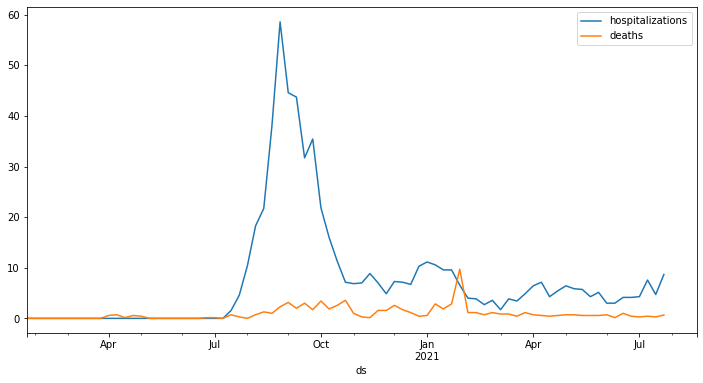

In [185]:
state_abbreviation = 'HI'

death_changepoint_range = .98
death_changepoint_prior_scale = 1
hosp_changepoint_range = .98
hosp_changepoint_prior_scale = 1

manual_check_data_load = open(f'pickled_data/state_vax_pred_pickled/{state_abbreviation}_vax_pred_df.pickle','rb')
manual_check_data = pickle.load(manual_check_data_load)
manual_check_data_load.close()

manual_tune(state_abbreviation,
            death_changepoint_range,
            death_changepoint_prior_scale,
            hosp_changepoint_range,
            hosp_changepoint_prior_scale)

make_model(state_abbreviation)

make_fig(state_abbreviation)

show_fig(state_abbreviation)
ax = manual_check_data.plot(x = 'ds', y = 'hospitalizations', figsize = (12,6))
manual_check_data.plot(x = 'ds', y = 'deaths', ax = ax)